# Detection of Fake Tweets about Disasters using NLP Text Classification


### Detection of Fake Tweets about Disasters using NLP text classification
The dataset used is the Kaggle dataset
https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset 
About the data:
- The basic objective task of the dataset has always been to create an algorithm that can determine if a given article is fake news or real. 
- The uploaded dataset is divided into two CSV files, ‘Fake.csv’ and ‘True.csv’. Combined there are a total of approximately 45,000 records. 
- There are only four columns in the dataset: title, text, subject and date. 
- The title of the news article is the headline itself while the text column contains the article text itself. 
- The subject column does not add much context to the dataset and the values are not consistent or balanced. 
- It most likely tries to describe the genre of the news each record belongs to. 
- The date of the record is simply the date when the article was published. The data is balanced since there are around 21,500 records in the ‘True’ file and approximately 23,500 records in the ‘False’ file. 

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split


In [23]:
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [24]:
train_data = pd.read_csv('data/train.csv')
train_data['IS_FAKE'] = 0 # Creating default column
train_data.head()

,id,keyword,location,text,target,IS_FAKE
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,0
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,0
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,0


In [25]:
test_data = pd.read_csv('data/test.csv')
test_data['IS_FAKE'] = 1 # Creating default column
test_data.head()

,id,keyword,location,text,IS_FAKE
0,0,NaN,NaN,Just happened a terrible car crash,1
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",1
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",1
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,1
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,1


In [26]:
news_data = pd.concat([train_data,test_data]).reset_index(drop = True)
news_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10876 entries, 0 to 10875
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        10876 non-null  int64  
 1   keyword   10789 non-null  object 
 2   location  7238 non-null   object 
 3   text      10876 non-null  object 
 4   target    7613 non-null   float64
 5   IS_FAKE   10876 non-null  int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 509.9+ KB


In [6]:
from pandas_profiling import ProfileReport
ProfileReport(news_data)
#prof = ProfileReport(news_data)
#prof.to_file(output_file='newsdata.html')

Render HTML: 100%|██████████| 1/1 [00:00<00:00,  6.17it/s]


In [27]:
news_data.describe()

,id,target,IS_FAKE
count,10876.000000,7613.00000,10876.000000
mean,5437.500000,0.42966,0.300018
std,3139.775098,0.49506,0.458287
min,0.000000,0.00000,0.000000
25%,2718.750000,0.00000,0.000000
50%,5437.500000,0.00000,0.000000
75%,8156.250000,1.00000,1.000000
max,10875.000000,1.00000,1.000000


In [28]:
news_data['location'].unique()

array([nan, 'Birmingham', 'Est. September 2012 - Bristol', ...,
       'Seattle Washington', 'Acey mountain islanddåÇTorontoåÈ',
       'Brussels, Belgium'], dtype=object)

In [29]:
news_data.IS_FAKE.value_counts()

0    7613
1    3263
Name: IS_FAKE, dtype: int64

In [30]:
news_data.isnull().sum()

id             0
keyword       87
location    3638
text           0
target      3263
IS_FAKE        0
dtype: int64

[Text(0, 0, '7613'), Text(0, 0, '3263')]

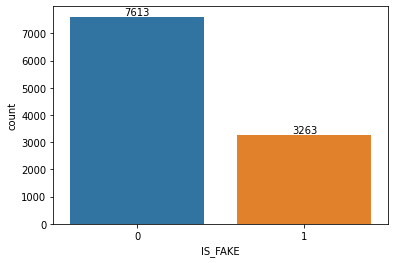

In [31]:
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
ax = sns.countplot(x=news_data['IS_FAKE'],
                   order=news_data['IS_FAKE'].value_counts(ascending=False).index)
abs_values = news_data['IS_FAKE'].value_counts(ascending=False).values
ax.bar_label(container=ax.containers[0], labels=abs_values)


In [32]:
news_data["text"].map(str)

0        Our Deeds are the Reason of this #earthquake M...
1                   Forest fire near La Ronge Sask. Canada
2        All residents asked to 'shelter in place' are ...
3        13,000 people receive #wildfires evacuation or...
4        Just got sent this photo from Ruby #Alaska as ...
                               ...                        
10871    EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
10872    Storm in RI worse than last hurricane. My city...
10873    Green Line derailment in Chicago http://t.co/U...
10874    MEG issues Hazardous Weather Outlook (HWO) htt...
10875    #CityofCalgary has activated its Municipal Eme...
Name: text, Length: 10876, dtype: object

In [33]:
y = news_data["IS_FAKE"]
y.head()

0    0
1    0
2    0
3    0
4    0
Name: IS_FAKE, dtype: int64

In [34]:
X_train, X_test, y_train, y_test = train_test_split(news_data["text"], y, test_size=0.2)
print(len(X_train),len(X_test), len(y_train), len(y_test)) 

8700 2176 8700 2176


In [35]:
embed_dim = 50
lstm_out = 64
batch_size = 32

max_words = 2000
max_len = 400

In [36]:
token = Tokenizer(num_words=max_words, lower=True, split=' ')
token.fit_on_texts(X_train.values)
sequences = token.texts_to_sequences(X_train.values)
train_sequences_padded = pad_sequences(sequences, maxlen=max_len)

In [37]:
model = Sequential()
model.add(Embedding(max_words, embed_dim, input_length = max_len))
model.add(LSTM(lstm_out))
model.add(Dense(5000, activation='relu'))
#model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, name='out_layer'))
model.add(Activation('sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 400, 50)           100000    
                                                                 
 lstm_1 (LSTM)               (None, 64)                29440     
                                                                 
 dense_3 (Dense)             (None, 5000)              325000    
                                                                 
 dense_4 (Dense)             (None, 128)               640128    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 out_layer (Dense)           (None, 1)                 129       
                                                                 
 activation_1 (Activation)   (None, 1)                

In [38]:
history = model.fit(train_sequences_padded, y_train, batch_size=batch_size, epochs = 5, validation_split=0.2)

Epoch 1/5


2022-01-25 12:05:35.135306: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-25 12:05:35.373961: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-25 12:05:36.441414: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


218/218 [==============================] - ETA: 0s - loss: 0.6176 - accuracy: 0.7006

2022-01-25 12:06:09.498114: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-25 12:06:09.559710: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


218/218 [==============================] - 39s 163ms/step - loss: 0.6176 - accuracy: 0.7006 - val_loss: 0.6123 - val_accuracy: 0.7000
Epoch 2/5
218/218 [==============================] - 31s 140ms/step - loss: 0.6114 - accuracy: 0.7010 - val_loss: 0.6112 - val_accuracy: 0.7000
Epoch 3/5
218/218 [==============================] - 30s 136ms/step - loss: 0.6116 - accuracy: 0.7010 - val_loss: 0.6129 - val_accuracy: 0.7000
Epoch 4/5
218/218 [==============================] - 30s 136ms/step - loss: 0.6080 - accuracy: 0.7010 - val_loss: 0.6195 - val_accuracy: 0.7000
Epoch 5/5
218/218 [==============================] - 30s 139ms/step - loss: 0.6047 - accuracy: 0.7010 - val_loss: 0.6190 - val_accuracy: 0.7000


In [39]:
#Comparing with test Data
test_sequences = token.texts_to_sequences(X_test)
test_sequences_padded = pad_sequences(test_sequences, maxlen=max_len)

In [40]:
model.evaluate(test_sequences_padded, y_test)

2022-01-25 12:10:50.464624: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-25 12:10:50.588951: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


68/68 [==============================] - 4s 43ms/step - loss: 0.6176 - accuracy: 0.6967


[0.6176201701164246, 0.6966911554336548]

([<matplotlib.axis.XTick at 0x28d0b1dc0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

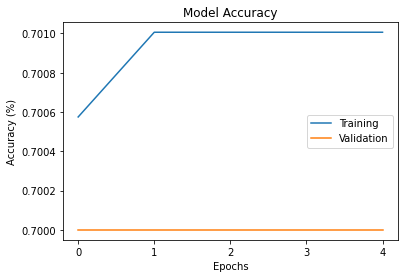

In [41]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.legend(['Training', 'Validation'])
plt.ylabel('Accuracy (%)')
plt.xlabel('Epochs')
plt.xticks([0,1,2,3,4])


([<matplotlib.axis.XTick at 0x287219c40>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

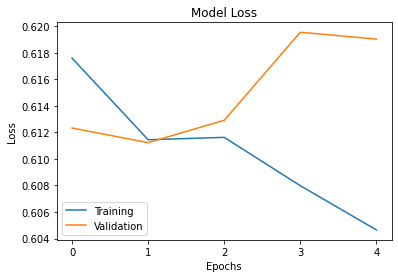

In [42]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.legend(['Training', 'Validation'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.xticks([0,1,2,3,4])